In [5]:
%pip install ace_tools


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# Load actual data
real_data_path = "VENTAS_TROCIUK3.csv"
df_real = pd.read_csv(real_data_path) 
df_real["FECHA"] = pd.to_datetime(df_real["FECHA"], format="%d/%m/%Y")

# Forecast folders
forecast_base = "forecasts"
models = ["prophet", "arima", "ETS"]

# Prepare result storage
results = []

# Iterate over models and their forecast files
for model in models:
    model_path = os.path.join(forecast_base, model)
    for file in os.listdir(model_path):
        if not file.endswith(".csv"):
            continue

        # Infer product from filename
        product = file.replace(f"_forecast_{model}.csv", "").replace("_", " ")

        # Load forecast
        forecast_df = pd.read_csv(os.path.join(model_path, file))
        forecast_df["ds"] = pd.to_datetime(forecast_df["ds"])
        forecast_df = forecast_df.rename(columns={"ds": "FECHA", "yhat": "FORECAST"})

        # Get real data for that product
        df_prod = df_real[df_real["DESCRIPCION"] == product].copy()
        df_prod = df_prod[["FECHA", "TOTAL_CANTIDAD"]]

        # Merge forecast with actuals
        merged = pd.merge(df_prod, forecast_df[["FECHA", "FORECAST"]], on="FECHA", how="inner")

        if merged.empty:
            continue

        # Calculate MAPE
        y_true = merged["TOTAL_CANTIDAD"].values
        y_pred = merged["FORECAST"].values
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100

        results.append({
            "Producto": product,
            "Modelo": model.upper(),
            "MAPE": round(mape, 2)
        })

        # Optional: Plot the actual vs forecast for this product
        plt.figure(figsize=(10, 5))
        plt.plot(merged["FECHA"], merged["TOTAL_CANTIDAD"], label="Real")
        plt.plot(merged["FECHA"], merged["FORECAST"], label=f"Forecast ({model.upper()})")
        plt.title(f"{product} - {model.upper()} vs Real")
        plt.xlabel("Fecha")
        plt.ylabel("Cantidad")
        plt.legend()
        plt.grid(True)
        plot_name = f"{forecast_base}/{product.replace(' ', '_')}_{model}_comparison.png"
        plt.savefig(plot_name)
        plt.close()
        print(f"Graph saved: {plot_name}")

# Create summary table
df_results = pd.DataFrame(results)
best_models = df_results.loc[df_results.groupby("Producto")["MAPE"].idxmin()].copy()
best_models = best_models.sort_values("MAPE")

# Save comparison table
summary_table_path = os.path.join(forecast_base, "model_comparison_summary.csv")
df_results.to_csv(summary_table_path, index=False)
print(f"Model comparison saved -> {summary_table_path}")



Graph saved: forecasts/Bovino_Engorde_High_Energy_50_Kg_prophet_comparison.png
Graph saved: forecasts/Aves_Crecimiento_25_Kg._prophet_comparison.png
Graph saved: forecasts/Equinos_Reproductor_25_Kg._prophet_comparison.png
Graph saved: forecasts/Cerdos_Crecimiento_50_Kg._prophet_comparison.png
Graph saved: forecasts/Lecheras_A.P._18%_-_50_Kg._prophet_comparison.png
Graph saved: forecasts/Lecheras_A.P._22%_Big_Bag_1.250_Kg._prophet_comparison.png
Graph saved: forecasts/Cerdos_Pre-inicial_25_Kg._prophet_comparison.png
Graph saved: forecasts/Pez_Crecimiento_Plus_-_32%_(5_-_7_mm)_25_Kg._prophet_comparison.png
Graph saved: forecasts/Aves_Unico_50_Kg._prophet_comparison.png
Graph saved: forecasts/Pez_Crecimiento_-_28%_(10_mm)_-_25_Kg_prophet_comparison.png
Graph saved: forecasts/Bovino_Destete_Precoz_50_Kg._prophet_comparison.png
Graph saved: forecasts/Aves_Crecimiento_Big_Bag_1250_kg._prophet_comparison.png
Graph saved: forecasts/Ovino_Plus_18%_-_25_Kg._prophet_comparison.png
Graph saved: fo

In [8]:
# Create summary table
df_results = pd.DataFrame(results)

# Get best model per product
best_models = df_results.loc[df_results.groupby("Producto")["MAPE"].idxmin()].copy()
best_models = best_models.sort_values("MAPE")

# Save full comparison
summary_table_path = os.path.join(forecast_base, "model_comparison_summary.csv")
df_results.to_csv(summary_table_path, index=False)
print(f"\n✅ Model comparison saved -> {summary_table_path}")

# Print full table
print("\n📊 Full Model Comparison (All Models per Product):")
print(df_results.to_string(index=False))

# Print best model per product
print("\n🏆 Best Model Per Product:")
print(best_models.to_string(index=False))



✅ Model comparison saved -> forecasts/model_comparison_summary.csv

📊 Full Model Comparison (All Models per Product):
                                          Producto  Modelo    MAPE
                  Bovino Engorde High Energy 50 Kg PROPHET  403.74
                           Aves Crecimiento 25 Kg. PROPHET  493.24
                        Equinos Reproductor 25 Kg. PROPHET  362.01
                         Cerdos Crecimiento 50 Kg. PROPHET  230.76
                        Lecheras A.P. 18% - 50 Kg. PROPHET  245.40
               Lecheras A.P. 22% Big Bag 1.250 Kg. PROPHET   31.69
                         Cerdos Pre-inicial 25 Kg. PROPHET   93.55
      Pez Crecimiento Plus - 32% (5 - 7 mm) 25 Kg. PROPHET  370.35
                                 Aves Unico 50 Kg. PROPHET  289.86
             Pez Crecimiento - 28% (10 mm) - 25 Kg PROPHET  459.83
                      Bovino Destete Precoz 50 Kg. PROPHET  468.93
                 Aves Crecimiento Big Bag 1250 kg. PROPHET    0.00
          

In [9]:
# ------------------------------
# 📈 Overall Model Performance
# ------------------------------
overall_performance = df_results.groupby("Modelo")["MAPE"].mean().reset_index()
overall_performance = overall_performance.sort_values("MAPE")

print("\n📊 Overall Model Performance (Average MAPE):")
print(overall_performance.to_string(index=False))



📊 Overall Model Performance (Average MAPE):
 Modelo       MAPE
PROPHET 269.487397
  ARIMA 274.760800


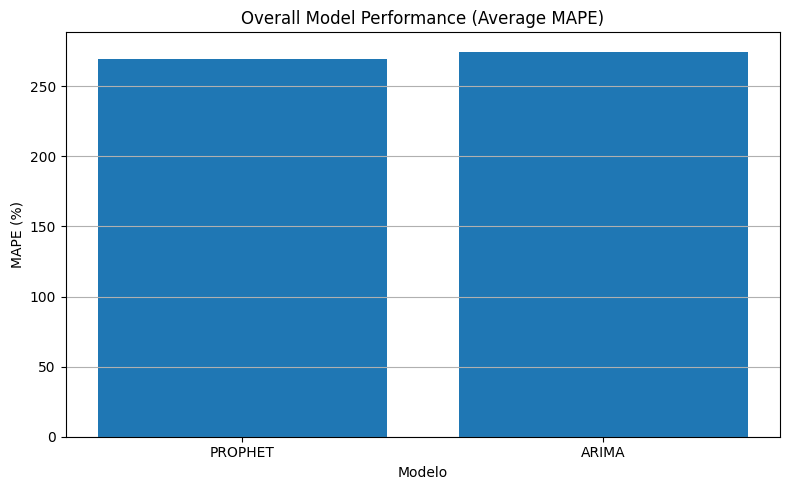


📉 Overall performance plot saved -> forecasts/overall_model_performance.png


In [10]:
import matplotlib.pyplot as plt

# Plot overall model performance
plt.figure(figsize=(8, 5))
plt.bar(overall_performance["Modelo"], overall_performance["MAPE"])
plt.title("Overall Model Performance (Average MAPE)")
plt.ylabel("MAPE (%)")
plt.xlabel("Modelo")
plt.grid(axis='y')
plt.tight_layout()

# Save the plot
plot_path = os.path.join(forecast_base, "overall_model_performance.png")
plt.savefig(plot_path)
plt.show()

print(f"\n📉 Overall performance plot saved -> {plot_path}")



📊 Overall Model Performance (Average MAPE - Only Prophet & ARIMA):
 Modelo       MAPE
PROPHET 269.487397
  ARIMA 274.760800


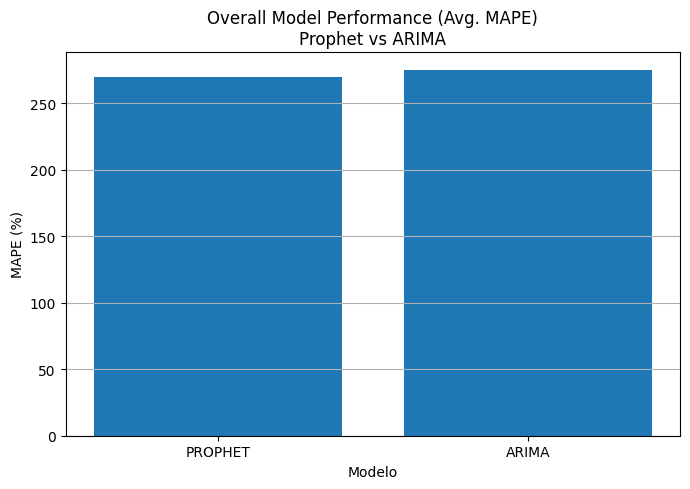


📉 Prophet vs ARIMA plot saved -> forecasts/overall_model_performance_prophet_arima.png


In [12]:
# ------------------------------
# 📈 Overall Model Performance (Only Prophet & ARIMA)
# ------------------------------
# Filter only models that actually have results
filtered_models = ["PROPHET", "ARIMA","ETS"]
overall_performance = (
    df_results[df_results["Modelo"].isin(filtered_models)]
    .groupby("Modelo")["MAPE"]
    .mean()
    .reset_index()
    .sort_values("MAPE")
)

print("\n📊 Overall Model Performance (Average MAPE - Only Prophet & ARIMA):")
print(overall_performance.to_string(index=False))

# Plot bar chart
plt.figure(figsize=(7, 5))
plt.bar(overall_performance["Modelo"], overall_performance["MAPE"])
plt.title("Overall Model Performance (Avg. MAPE)\nProphet vs ARIMA")
plt.ylabel("MAPE (%)")
plt.xlabel("Modelo")
plt.grid(axis='y')
plt.tight_layout()

# Save and show
plot_path = os.path.join(forecast_base, "overall_model_performance_prophet_arima.png")
plt.savefig(plot_path)
plt.show()

print(f"\n📉 Prophet vs ARIMA plot saved -> {plot_path}")
